# NYC Taxi Fare Prediction

##### Kaggle Blurb
In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of 5-8 dollars, depending on the model used.

##### My Approach
While there are plenty of submissions and Medium articles on this particular problem, I'm going to take a bit of a different approach.

Taxi fares in most towns and small cities are a direct function of time spent driving. NYC is a different beast. Depending on time of day, destination, speed of traffic etc, fares are surcharged at additional per minute rates and flat rates. I'm going to see if building a model that significantly improves on Google's baseline error can be achieved by stripping fares of their surcharges, making predictions using a highly conservative set of features, and using a rules-based function to add surcharges to predictions. I'll then compare that approach to one which ingests surcharge rules as features rather than in post-processing. 

In [53]:
# Module imports
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The raw dataset is on the order of 60m rows, far too many to process locally on this Macbook. Reading some other approaches to the problem, 2m rows has been getting good results so I'll start with that. 

In [54]:
filepath = r'/Users/anthonybaum/Documents/data_science_portfolio/nyc_taxi_fares/'
fares_train = pd.read_csv(filepath + 'train.csv', nrows=2000000)

In [55]:
fares_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [56]:
# Need to cast the datetime column as a datetime
fares_train['pickup_datetime'] = pd.to_datetime(fares_train.pickup_datetime)

To kickstart the project, I'm going to create a rudimentary model to set a working baseline. The model will be optimized to the point that the error falls within the RMSE range given in the Kaggle blurb. 

First, some data cleansing and creating the key distance travelled feature. For that I'll use the Haversine formula.

In [57]:
# Checking for nulls
print(fares_train.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64


In [58]:
# There are null values in the dropoff columns so we'll just drop those rows
fares_train = fares_train.dropna()

In [59]:
print(fares_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


For fare amount, the values need to be sanity checked. Intuitively, the fare cannot be less than 0. Furthermore, every taxi trip in NYC has a base fare of 2.50, so anything below that will be considered bad data. Outputting the min and max fare values below shows that values exist outside of those constraints. There's also a singular huge outlier. We can set a rule that training fares should be below 1000 dollars, which will generalize well to other subsets of data since we're only using 10% of the training set provided right now. 

In [60]:
print(fares_train.fare_amount.min(), fares_train.fare_amount.max())
print(fares_train.fare_amount.sort_values(ascending=False)[:10].tolist())

-62.0 1273.31
[1273.31, 500.0, 495.0, 488.0, 450.0, 450.0, 450.0, 430.0, 400.0, 400.0]


In [61]:
# Constraining fares to real world values
fares_train = fares_train.loc[(fares_train.fare_amount >= 2.5) & (fares_train.fare_amount < 1000)]

Similarly for passenger count, the data must represent real world values. According to the NYC Taxi & Limousine Commission, the largest vehicle (by seats) eligible for a medallion is the Nissan NV200 passenger van with 12 seats. The Ford Transit Connect is also on the list, but only wheelchair accesible versions which are limited to 6 seats. 

Allowed vehicle source: https://www1.nyc.gov/site/tlc/about/vehicles-in-use-approved-vehicle-list.page

Seating data sourced from vehicle manufacturer websites. 

The passenger count data will, as such, be constrained to 1 >= n <= 12  

In [62]:
fares_train = fares_train.loc[(fares_train.passenger_count >= 1) & (fares_train.passenger_count <= 12)]
print(fares_train.passenger_count.min(), fares_train.passenger_count.max())

1 9


The geospatial data needs to make real world sense too. Since the project is limited to NYC, any lat/longs unreasonably far from NYC need to be removed. Checking rounded values in the pickup_longitude column reveals a significant number of values that are clearly errounous.

In [63]:
fares_train['pickup_longitude'].astype(int).unique()

array([  -73,   -74,     0,    40,   -72,   -75,    -1,   -70,  -736,
         -78,    -7,   -69,  2140,   -10,   -76,   -71,  -121,  -740,
         -67,   -77,   -80,   -66,    -3,  -128, -2986, -3377,  -735,
         -89, -1452,  2522,   -65,   -90,   -62,  -108,   -94,    -8,
         -79,   351,   -29, -3007,  1721,   -84,  2417, -2256,   -83,
        -322,  2434, -1649, -1182, -2647,   -49, -2973,    -4,   -60,
       -1329,  2814,    -9, -2320,  2856,   -56,   -54,   -42, -1659,
         -88,   -51,  -797,   -93,   -82,    -5])

The rough lat/long of lower Manhattan is 41.71N, 74W. One degree of latitude is roughly 69 miles. Anything drastically different is definitely errounous, and any legitimate journey of greater than around one degree is an outlier and will bias the model. As such, it only makes sense to keep data within a couple of degrees of the city, so we can set the latitudinal bounds as 40N and 43N, and the longitudinal bounds as 73W and 75W.

In [64]:
fares_train = fares_train.loc[((fares_train.pickup_latitude >= 40) & (fares_train.pickup_latitude <= 43)) &
                              ((fares_train.dropoff_latitude >= 40) & (fares_train.dropoff_latitude <= 43)) &
                              ((fares_train.pickup_longitude <= -73) & (fares_train.pickup_longitude >= -75)) &
                              ((fares_train.dropoff_longitude <= -73) & (fares_train.dropoff_longitude >= -75))]

Now I'll build the distance travelled feature implementing a function using the Haversine formula. There's also an opportunity do an a additional bit of cleaning here by ensuring distances are all > 0. 

In [65]:
fares_train['pickup_coords'] = list(zip(fares_train.pickup_latitude, fares_train.pickup_longitude))
fares_train['dropoff_coords'] = list(zip(fares_train.dropoff_latitude, fares_train.dropoff_longitude))
fares_train.drop(['pickup_longitude', 
                  'pickup_latitude', 
                  'dropoff_longitude', 
                  'dropoff_latitude'],
                 axis=1,
                 inplace=True)

In [66]:
def calculate_distance(row):
    
    from math import radians, cos, sin, asin, sqrt
    
    lat1 = row.pickup_coords[0]
    lon1 = row.pickup_coords[1]
    lat2 = row.dropoff_coords[0]
    lon2 = row.dropoff_coords[1]

    R = 6372.8 # using km as unit of measure

    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return R * c
    

fares_train['dist'] = fares_train.apply(calculate_distance, axis=1)

fares_train = fares_train.loc[fares_train.dist > 0]

Now to get onto making the appropriate features ML ready. For this first iteration, only distance travelled will be used as the training feature, to make sure we're in the ballpark given by the blurb from kaggle. Similarly, a simple linear regression will suffice just fine. 

This time round, data won't be normalized, but will be required with additional feature engineering.

In [75]:
def linear_model(data, training_cols, target):

    X, y = data[training_cols], data[target]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    from sklearn.linear_model import LinearRegression 
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
    
    
linear_model(data=fares_train, training_cols=['dist'], target='fare_amount')

RMSE: 5.249036562166437


This is good stuff. The RMSE falls within the 5-8 range targeted even with a small sample of the overall dataset, so the model build is definitely on the right track. 

Only distance travelled was used to train that initial model. For NYC taxis, a fairly complex fare system exists. Here are the rules:

### Standard Metered Fare
- 2.50 initial charge.
- Plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.
- Plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
- Plus 30 cents Improvement Surcharge.
- Plus 50 cents overnight surcharge 8pm to 6am.
- Plus 1.00 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.
- Plus New York State Congestion Surcharge of 2.50 (Yellow Taxi) or 2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
- Plus tips and any tolls.
- There is no charge for extra passengers, luggage or bags, or paying by credit card.

### Destinations Beyond NYC
- Westchester & Nassau Counties:
    - The on-screen rate is "Rate #01 – Standard City Rate" within the City limit.
    - Once the taxi goes beyond the City limit to Nassau or Westchester, the on-screen rate message should read "Rate #04 – Out of -- City Rate to Nassau or Westchester." The metered fare is double the amount from the City limit to your destination.
    - Additionally, a message should appear on screen alerting the passenger of the rate change.
    - There is a 50 cents MTA State Surcharge and a 30 cents Improvement Surcharge.
    - Plus New York State Congestion Surcharge of 2.50 (Yellow Taxi) or .75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
- Other Points Outside the City:
    - The Driver may choose whether to take such trips. The fare must be mutually agreed upon before the trip may begin.
    - Negotiated Flat Fare – The fare will be a Flat Rate negotiated between the Driver and Passenger.
    - The onscreen rate message should read "Rate #05 – Out of City Negotiated Flat Rate."
    - The 50 cents MTA State Surcharge must be added to the flat rate for any trip that ends in the following counties: Dutchess, Orange, Putnam, Rockland or Suffolk.
    - There is a 30 cents Improvement Surcharge.
    - Plus New York State Congestion Surcharge of 2.50 (Yellow Taxi) or 2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.

### Tolls
- Drivers must use an E-ZPass when taking a toll bridge or tunnel.  Discounted E-ZPass tolls will be added to the passenger fare at the end of the trip.
- Passengers must pay the tolls to and from a distination for the following trips:
    - Westchester and Nassau Counties
    - Trips over the Cross Bay Veterans and Marine Parkway-Gil Hodges Memorial Bridges
    - Newark Airport (EWR)

### Airport Trips
- Trips to and from LaGuardia Airport (LGA) are charged the standard metered fare.
- Trips between Manhattan and John F. Kennedy Airport (JFK) in either direction: 52.
    - Plus 50 cents MTA State Surcharge.
    - Plus 30 cents Improvement Surcharge.
    - 4.50 rush hour surcharge (4pm to 8pm weekdays, excluding legal holidays).
    - Plus New York State Congestion Surcharge of 2.50 (Yellow Taxi) or 2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
    - Plus tips and any tolls.
    - The on-screen rate message should read "Rate #2- JFK Airport."
- Trips between John F. Kennedy Airport (JFK) and other New York City destinations are charged the standard metered fare.
- Trips to Newark Airport (EWR): Standard metered fair.
    - Plus 17.50 Newark Surcharge.
    - Plus 30 cents Improvement Surcharge.
    - Plus New York State Congestion Surcharge of 2.50 (Yellow Taxi) or 2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
    - Plus tip and tolls to and from EWR (passengers are charged for the drivers’ return tolls).
    - The on-screen rate message should read "Rate #3 - Newark Airport."

That's a ton of rules which would be extremely time consuming to code, so parsing out the most common/impactful ones will be the most productive use of time. So what are those?
- 2.50 base charge on every fare. 
- 1.00 surcharge between the hours of 4pm and 8pm on weekdays, excluding holidays. 
- 0.50 overnight surcharge between hours of 8pm and 6am. 
- 0.30 Improvement surcharges to every fare. 
- 2.50/2.75/0.75 charge for all trips beginning south of 96th St depending on ride type. 
- Hudson River crossings and some East River crossings have tolls. 
- Trips to/from JFK have a flat rate of 52.00 with a 4.50 surcharge between 4pm and 8pm excluding holidays. 
- Trips to EWR have a 17.50 surcharge. 

Creating an adjusted fare feature to isolate the fare for distance travelled minus fees is probably a good bet.

In [76]:
# To create the adjusted fare the surcharges need to be removed from the actual charge to the passenger

def adjust_fare_paid(row):
    
    af = row.fare_amount # af: adjusted fare
    ride_datetime = row.pickup_datetime
    
    trip_time = ride_datetime.time()
    trip_day = ride_datetime.isoweekday() # Mon = 1, Sun = 7
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    eight_pm_ts = dt.datetime.strptime('20:00', '%H:%M').time()
    six_am_ts = dt.datetime.strptime('06:00', '%H:%M').time()
    four_pm_ts = dt.datetime.strptime('16:00', '%H:%M').time()
    
    # Base fare
    af -= 2.50 # accounts for base fare
    
    # Evening rush hour surcharge
    if trip_time > four_pm_ts and trip_time < eight_pm_ts and trip_day <= 5:
        af -= 1
    else: 
        pass
    
    # Overnight surcharge
    if trip_time > eight_pm_ts or trip_time < six_am_ts:
        af -= 0.5
    else: 
        pass    
    
    # Improvement surcharge
    af -= 0.3
    
    # Trips below 96th
    # South and west of the east end of 96th St
    # Some accuracy lost as 96th runs NW but tradeoff is no falsely assigned surcharges
    if pu_coords[0] < 40.782799 and pu_coords[1] > -73.936949:
        af -= 2.50
    
    # Bridge tolls
    # All bridges across the east river between Queens/Bronx/Upper Manhattan have an $8.50 toll
    # Note, bridges south of Randalls Island have no tolls, and we'll have to take an accuacy hit for the Midtown tunnel
    # Without having to use intensive geospatial code, we can approximate trips that crossed those northern bridges
    # The coords (40.795268, -73.928113) are near Randalls Island, in between Queens, the Bronx, and Harlem
    # The majority of the Bronx is east and north, majority of Queens is east and south, upper Manhattan is west and north
    # Trips that start/end east of that point and crossed the latitude used one of the bridges
    # Trips that start/end west of the point and cross E/W AND N/S crossed the Triborough bridge
    # Manhattan - Queens trips
    if pu_coords[0] > 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] < 40.795268 and do_coords[1] > -73.928113:
        af -= 8.50
    # Queens - Manhattan trips
    elif pu_coords[0] < 40.795268 and pu_coords[1] > -73.928113 and do_coords[0] > 40.795268 and do_coords[1] < -73.928113:
        af -= 8.50
    # Bronx - Queens trips
    elif pu_coords[0] > 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] < 40.795268 and do_coords[1] < -73.928113:
        af -= 8.50
    # Queens - Bronx trips
    elif pu_coords[0] < 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] > 40.795268 and do_coords[1] < -73.928113:
        af -= 8.50
    else:
        pass

    
    return af


fares_train['adjusted_fare'] = fares_train.apply(adjust_fare_paid, axis=1)

On top of surcharges and bridge tolls, airport rides are intuitively a significant contributor to the dataset. We can see from the visualization below that all three airport are clearly defined, meaning a lot of trips for each. For those unfamiliar with the city's geography, the relevant clustered points are JFK on the bottom right, LGA center right, EWR on the far left. LGA has no special fare rules so doesn't need to be accounted for. JFK and EWR do, though. 

JFK has a flat rate fare, so it makes sense to assign a boolean categorical feature to runs that start or end there. EWR has a surcharge on top of a standard metered fare so an adjustment to our adjusted fare feature is more appropriate. 

(40.625, 40.873)

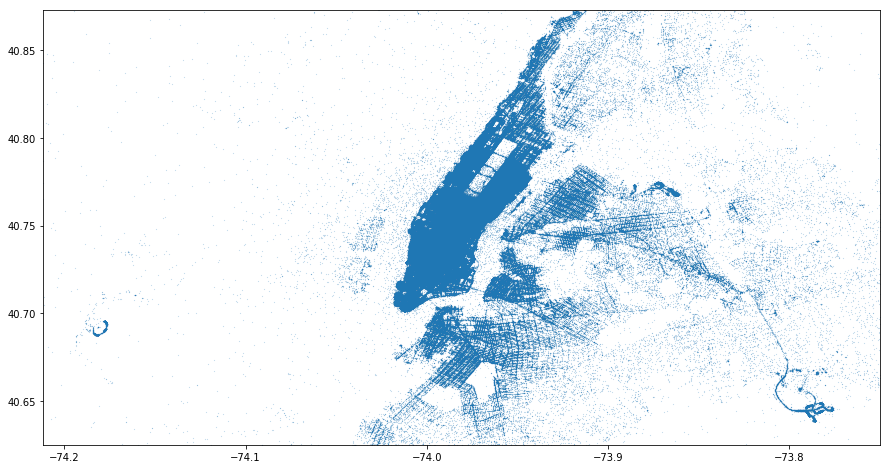

In [77]:
do_lats = [i[0] for i in fares_train.dropoff_coords.tolist()]
do_lons = [i[1] for i in fares_train.dropoff_coords.tolist()]

fig = plt.figure(figsize=(15,8))
plt.scatter(x=do_lons, y=do_lats, s=0.008)
plt.xlim((-74.211938, -73.75))
plt.ylim((40.625, 40.873))

In [78]:
# JFK trips
def is_jfk_trip(row):
    
    # NW 40.661947, -73.808848
    # NE 40.653712, -73.771211
    # SW 40.641392, -73.807694
    # SE 40.639457, -73.761142
    # Center point 40.645925, -73.785512, 3kft lat 40.655189, 3kft lon -73.762359
    ctr_lat = 40.645925
    ctr_lon = -73.785512
    
    ride_datetime = row.pickup_datetime
    
    trip_time = ride_datetime.time()
    trip_day = ride_datetime.isoweekday() # Mon = 1, Sun = 7
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    eight_pm_ts = dt.datetime.strptime('20:00', '%H:%M').time()
    four_pm_ts = dt.datetime.strptime('16:00', '%H:%M').time()
    
    # Using np.abs we can check if pickup/dropoff falls within ~3000ft of the center point of the airport
    # This encompasses all airline terminals
    is_jfk_bool = False
    if np.abs(pu_coords[0] - ctr_lat) < 0.015 and np.abs(pu_coords[1] - ctr_lon) < 0.025:
        is_jfk_bool = True
    elif np.abs(do_coords[0] - ctr_lat) < 0.015 and np.abs(do_coords[1] - ctr_lon) < 0.025:
        is_jfk_bool = True
    else:
        pass
    
    if is_jfk_bool == True:
        # JFK has an extra surcharge of 4.50 for rush hour trips. 1.00 was already accounted for in the earlier fare adjustment
        if trip_time >= four_pm_ts and trip_time < eight_pm_ts and trip_day <= 5:
            row.adjusted_fare -= 3.50
        return 1
    else:
        return 0
    
fares_train['is_jfk_trip'] = fares_train.apply(is_jfk_trip, axis=1)

In [79]:
# EWR trips
# Trips TO EWR have a standard metered fare plus a 17.50 surcharge
def is_ewr_trip(row):
    
    ctr_lat = 40.691946
    ctr_lon = -74.180670
    do_coords = row.dropoff_coords
    output_adjusted_fare = row.adjusted_fare
    
    # Only need to account for dropoffs
    if np.abs(do_coords[0] - ctr_lat) < 0.015 and np.abs(do_coords[1] - ctr_lon) < 0.025:
        row.adjusted_fare -= 17.50
        return 1 
    else:
        return 0
    
fares_train['is_ewr_trip'] = fares_train.apply(is_ewr_trip, axis=1)

Once again, we need to sanity check the data. After the surcharge/toll/airport processing, let's check how it's affected the data.

In [80]:
print('% fares below 0:', (len(fares_train.loc[fares_train.adjusted_fare < 0]) / (len(fares_train)))*100)
print('JFK trips:', len(fares_train.loc[fares_train.is_jfk_trip == 1]))
print('Mean fare adjustment:', np.mean(fares_train.fare_amount - fares_train.adjusted_fare))

% fares below 0: 0.0
JFK trips: 40839
Mean fare adjustment: 3.4736617951393614


A small percentage of fares have been adjusted to be below 0 dollars, however the mean fare adjustment is close to surcharges the majority of "not-special" rides would have (i.e. no tolls or airports). The values below zero are almost certainly victims of the geospatial assumptions, so we need to lose them. It's small amount of data loss for gaining a far more accurate representation of the fare to distance relationship. 

In [81]:
fares_train = fares_train.loc[fares_train.adjusted_fare > 0]

Now we can run the linear regression function we created earlier using adjusted fare as the target instead of the original fare listed.

In [82]:
linear_model(fares_train, ['dist'], 'adjusted_fare')

RMSE: 5.411643684402154


On this particular subset of data, error has improved around 30 cents from just improving the accuracy of the fare. Since the model function was built to accept a list of columns as the training cols, we can also utilize the categorical features we created for JFK and EWR trips as well as passenger count. 

In [83]:
linear_model(fares_train, ['dist', 'is_jfk_trip', 'is_ewr_trip', 'passenger_count'], 'adjusted_fare')

RMSE: 5.223576952160411


So roughly a 5 cent improvement by adding those extra features. 

- A couple of easy features to add are also evident. 
    - Taxi fares cost more sitting in traffic. We haven't accounted for rush hour congestion around popular spots. 
    - From the map created above, three standout choke points we haven't accounted for are LGA airport, Midtown, and FiDi. 
- Values based on time would also be helpful. E.g. day of week and perhaps an is_rush_hour categorical feature. 

We'll create those now. 

In [84]:
# LGA airport 
def is_lga_trip(row):
        
    ctr_lat = 40.774120
    ctr_lon = -73.868192
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    if np.abs(do_coords[0] - ctr_lat) < 0.01 and np.abs(do_coords[1] - ctr_lon) < 0.015:
        return 1 
    elif np.abs(pu_coords[0] - ctr_lat) < 0.01 and np.abs(pu_coords[1] - ctr_lon) < 0.015:
        return 1
    else:
        return 0
    
    
fares_train['is_lga_trip'] = fares_train.apply(is_lga_trip, axis=1)

In [85]:
# Midtown
def is_midtown_trip(row):
        
    ctr_lat = 40.761589
    ctr_lon = -73.981435
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    if np.abs(do_coords[0] - ctr_lat) < 0.02 and np.abs(do_coords[1] - ctr_lon) < 0.02:
        return 1 
    elif np.abs(pu_coords[0] - ctr_lat) < 0.02 and np.abs(pu_coords[1] - ctr_lon) < 0.02:
        return 1
    else:
        return 0
    
    
fares_train['is_midtown_trip'] = fares_train.apply(is_midtown_trip, axis=1)

In [86]:
# FiDi
def is_fidi_trip(row):
        
    ctr_lat = 40.714092
    ctr_lon = -73.981435
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    if np.abs(do_coords[0] - ctr_lat) < 0.15 and np.abs(do_coords[1] - ctr_lon) < 0.15:
        return 1 
    elif np.abs(pu_coords[0] - ctr_lat) < 0.15 and np.abs(pu_coords[1] - ctr_lon) < 0.15:
        return 1
    else:
        return 0
    
    
fares_train['is_fidi_trip'] = fares_train.apply(is_fidi_trip, axis=1)

In [87]:
# Weekday categorical
def is_weekday(row):
    
    trip_day = row.pickup_datetime.isoweekday() # Mon = 1, Sun = 7
    
    if trip_day <= 5:
        return 1
    else:
        return 0


fares_train['is_weekday'] = fares_train.apply(is_weekday, axis=1)

In [88]:
# Weekday rush categorical
def is_weekday_rush(row):
    
    ride_datetime = row.pickup_datetime
    trip_time = ride_datetime.time()
    trip_day = ride_datetime.isoweekday() # Mon = 1, Sun = 7
    
    eight_pm_ts = dt.datetime.strptime('20:00', '%H:%M').time()
    four_pm_ts = dt.datetime.strptime('16:00', '%H:%M').time()
    
    if trip_time >= four_pm_ts and trip_time < eight_pm_ts and trip_day <= 5:
        return 1
    else:
        return 0
    

fares_train['is_weekday_rush'] = fares_train.apply(is_weekday_rush, axis=1)

We should check the RMSE improvement with these new features. 

In [89]:
model(fares_train, ['dist', 
                    'is_jfk_trip', 
                    'is_ewr_trip', 
                    'is_lga_trip', 
                    'is_midtown_trip', 
                    'is_fidi_trip', 
                    'passenger_count',
                    'is_weekday',
                    'is_weekday_rush'], 
                    'adjusted_fare')

TypeError: model() missing 1 required positional argument: 'target'

Of course the adjusted fare is not the actual fare we need to predict, we need to be able to add back the surcharges to our models predictions. The final RMSE for our baseline linear model should be modelled adjusted fare + appropriate charges scored against the actual fare paid. 

We'll create a function to add the appropriate charges then apply the function within a modified version of the basic_linear_model function we already built. 

In [ ]:
# Using the fare adjustment function from earlier, we can switch some things back around
def apply_approriate_charges(row):
    
    pf = row.adj_predicted_fare
    
    ride_datetime = row.pickup_datetime
    
    trip_time = ride_datetime.time()
    trip_day = ride_datetime.isoweekday() # Mon = 1, Sun = 7
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    eight_pm_ts = dt.datetime.strptime('20:00', '%H:%M').time()
    six_am_ts = dt.datetime.strptime('06:00', '%H:%M').time()
    four_pm_ts = dt.datetime.strptime('16:00', '%H:%M').time()
    
    # Base fare
    pf += 2.50 # accounts for base fare
    
    # Evening rush hour surcharge
    if trip_time > four_pm_ts and trip_time < eight_pm_ts and trip_day <= 5:
        pf += 1
    else: 
        pass
    
    # Overnight surcharge
    if trip_time > eight_pm_ts or trip_time < six_am_ts:
        pf += 0.5
    else: 
        pass    
    
    # Improvement surcharge
    pf += 0.3
    
    # Trips below 96th
    # South and west of the east end of 96th St
    # Some accuracy lost as 96th runs NW but tradeoff is no falsely assigned surcharges
    if pu_coords[0] < 40.782799 and pu_coords[1] > -73.936949:
        pf += 2.50
    
    # Bridge tolls
    # All bridges across the east river between Queens/Bronx/Upper Manhattan have an $8.50 toll
    # Note, bridges south of Randalls Island have no tolls, and we'll have to take an accuacy hit for the Midtown tunnel
    # Without having to use intensive geospatial code, we can approximate trips that crossed those northern bridges
    # The coords (40.795268, -73.928113) are near Randalls Island, in between Queens, the Bronx, and Harlem
    # The majority of the Bronx is east and north, majority of Queens is east and south, upper Manhattan is west and north
    # Trips that start/end east of that point and crossed the latitude used one of the bridges
    # Trips that start/end west of the point and cross E/W AND N/S crossed the Triborough bridge
    # Manhattan - Queens trips
    if pu_coords[0] > 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] < 40.795268 and do_coords[1] > -73.928113:
        pf -= 8.50
    # Queens - Manhattan trips
    elif pu_coords[0] < 40.795268 and pu_coords[1] > -73.928113 and do_coords[0] > 40.795268 and do_coords[1] < -73.928113:
        pf -= 8.50
    # Bronx - Queens trips
    elif pu_coords[0] > 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] < 40.795268 and do_coords[1] < -73.928113:
        pf -= 8.50
    # Queens - Bronx trips
    elif pu_coords[0] < 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] > 40.795268 and do_coords[1] < -73.928113:
        pf -= 8.50
    else:
        pass
    
    # EWR surcharge
    ewr_lat = 40.691946
    ewr_lon = -74.180670
    do_coords = row.dropoff_coords
    
    # Only need to account for dropoffs
    if np.abs(do_coords[0] - ewr_lat) < 0.015 and np.abs(do_coords[1] - ewr_lon) < 0.025:
        pf += 17.50
    
    return pf

Now taking the exact linear regression function from earlier, we can add in the real fare adjustment.

In [ ]:
def full_fare_linear_model(data, training_cols, target):
    
    X, y = data[training_cols], data[target]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    from sklearn.linear_model import LinearRegression
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Adjusted fare RMSE:', rmse)
    print('')
    
    # Applying surcharges to predictions and testing error
    charges_applied_data = data.copy() 
    charges_applied_data['adj_predicted_fare'] = model.predict(charges_applied_data[training_cols])
    charges_applied_data['fare_with_charges'] = charges_applied_data.apply(apply_approriate_charges, axis=1)
    y_true_full_fare = charges_applied_data.fare_amount
    y_pred_full_fare = charges_applied_data.fare_with_charges
    
    new_mse = mean_squared_error(y_true_full_fare, y_pred_full_fare)
    new_rmse = np.sqrt(new_mse)
    print('Fare with charges RMSE:', new_rmse)
    
    return(charges_applied_data)


In [ ]:
training_cols = ['dist', 
                 'is_jfk_trip', 
                 'is_ewr_trip', 
                 'is_lga_trip', 
                 'is_midtown_trip', 
                 'is_fidi_trip', 
                 'passenger_count',
                 'is_weekday',
                 'is_weekday_rush']

charges_applied_df = full_fare_linear_model(fares_train, training_cols, 'adjusted_fare')

Using surcharge agnostic fare predictions and adding surcharges later has knocked another 10 cents off the error score. Since this is still a Linear Regression as we've been using all along, we can test this workflow with a more complex model. 

In [ ]:
fares_train.info()

A score under 5 will be good, as it'll be beating the the range initially set for a basic distance to fare model. Trying a few models (including GradientBoostingRegressor) reveals that the best full fare RMSE is the RandomForestRegressor.

In [ ]:
def rf_reg_model(data, training_cols, target):
    
    X, y = data[training_cols], data[target]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Adjusted fare RMSE:', rmse)
    
    # Applying surcharges to predictions and testing error
    charges_applied_data = data.copy() 
    charges_applied_data['adj_predicted_fare'] = model.predict(charges_applied_data[training_cols])
    charges_applied_data['fare_with_charges'] = charges_applied_data.apply(apply_approriate_charges, axis=1)
    new_mse = mean_squared_error(charges_applied_data.fare_amount, charges_applied_data.fare_with_charges)
    new_rmse = np.sqrt(new_mse)
    print('Charges Applied RMSE:', new_rmse)

rf_reg_model(fares_train, training_cols, 'adjusted_fare')

A couple of tests to conduct now with hyperparameter optimization. 

def final_model(data, training_cols, target):
    
    X, y = data[training_cols], data[target]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    from sklearn.ensemble import RandomForestRegressor
        
    estimators_array = np.arange(10, 101, 20)
    max_depth_array = np.arange(3, 10, 1)
    
    error_list = []
    for i in max_depth_array:
    
        model = RandomForestRegressor(n_estimators=100, max_depth=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        from sklearn.metrics import mean_squared_error
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        #print('Adjusted fare RMSE:', rmse)

        # Applying surcharges to predictions and testing error
        charges_applied_data = data.copy() 
        charges_applied_data['adj_predicted_fare'] = model.predict(charges_applied_data[training_cols])
        charges_applied_data['fare_with_charges'] = charges_applied_data.apply(apply_approriate_charges, axis=1)
        new_mse = mean_squared_error(charges_applied_data.fare_amount, charges_applied_data.fare_with_charges)
        new_rmse = np.sqrt(new_mse)
        #rint('Full fare RMSE:', new_rmse)
        error_list.append(new_rmse)
        
    print(error_list)
    
    return error_list

final_model(fares_train, training_cols, 'adjusted_fare')